# Exercise 4. - Data Cleansing

## Handling Missing Values in Python

![Missing values](missing.png)

Real world data is messy and often contains a lot of missing values. 

There could be multiple reasons for the missing values but primarily the reason for missingness can be attributed to:

| Reason for missing Data | 
| :-----------: | 
| Data doesn't exist |
| Data not collected due to human error. | 
| Data deleted accidently |

## A guide to handling missing values 

Please read this tutorial on handling missing values first, before working on dirty data this week: [TUTORIAL](a_guide_to_na.ipynb).

# Dirty data

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import warnings
import ssl
# Suppress warnings
warnings.filterwarnings('ignore')
# Disable SSL verification
ssl._create_default_https_context = ssl._create_unverified_context
import requests
from io import StringIO

Load the dataset from the provided URL using pandas.

In [2]:
url = "https://raw.github.com/edwindj/datacleaning/master/data/dirty_iris.csv"
response = requests.get(url, verify=False)
data = StringIO(response.text)
dirty_iris = pd.read_csv(data, sep=",")
print(dirty_iris.head())

   Sepal.Length  Sepal.Width  Petal.Length  Petal.Width     Species
0           6.4          3.2           4.5          1.5  versicolor
1           6.3          3.3           6.0          2.5   virginica
2           6.2          NaN           5.4          2.3   virginica
3           5.0          3.4           1.6          0.4      setosa
4           5.7          2.6           3.5          1.0  versicolor


## Introduce Missing Values

Randomly introduce missing values into the dataset to mimic the Python code behavior.

In [3]:
# Load additional data
carseats = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/Carseats.csv")

# Set random seed for reproducibility
np.random.seed(123)

# Introduce missing values in 'Income' column
income_missing_indices = np.random.choice(carseats.index, size=20, replace=False)
carseats.loc[income_missing_indices, 'Income'] = np.nan

# Set another random seed for reproducibility
np.random.seed(456)

# Introduce missing values in 'Urban' column
urban_missing_indices = np.random.choice(carseats.index, size=10, replace=False)
carseats.loc[urban_missing_indices, 'Urban'] = np.nan



# Introduction

Analysis of data is a process of inspecting, cleaning, transforming, and modeling data with the goal of highlighting useful information, suggesting conclusions and supporting decision making.

![Descriptive Statistics](images/ds.png)

Many times in the beginning we spend hours on handling problems with missing values, logical inconsistencies or outliers in our datasets. In this tutorial we will go through the most popular techniques in data cleansing.


We will be working with the messy dataset `iris`. Originally published at UCI Machine Learning Repository: Iris Data Set, this small dataset from 1936 is often used for testing out machine learning algorithms and visualizations. Each row of the table represents an iris flower, including its species and dimensions of its botanical parts, sepal and petal, in centimeters.

Take a look at this dataset here:

In [4]:
dirty_iris

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,6.4,3.2,4.5,1.5,versicolor
1,6.3,3.3,6.0,2.5,virginica
2,6.2,NaN,5.4,2.3,virginica
3,5.0,3.4,1.6,0.4,setosa
4,5.7,2.6,3.5,1.0,versicolor
...,...,...,...,...,...
145,6.7,3.1,5.6,2.4,virginica
146,5.6,3.0,4.5,1.5,versicolor
147,5.2,3.5,1.5,0.2,setosa
148,6.4,3.1,NaN,1.8,virginica


## Detecting NA

A missing value, represented by NaN in Python, is a placeholder for a datum of which the type is known but its value isn't. Therefore, it is impossible to perform statistical analysis on data where one or more values in the data are missing. One may choose to either omit elements from a dataset that contain missing values or to impute a value, but missingness is something to be dealt with prior to any analysis.


![Descriptive Statistics](images/ds.png)

Can you see that many values in our dataset have status NaN = Not Available? Count (or plot), how many (%) of all 150 rows is complete.


In [5]:
# Count the number of complete cases (rows without any missing values)
complete_cases = dirty_iris.dropna().shape[0]

# Calculate the percentage of complete cases
percentage_complete = (complete_cases / dirty_iris.shape[0]) * 100

print(f"Number of complete cases: {complete_cases}")
print(f"Percentage of complete cases: {percentage_complete:.2f}%")

Number of complete cases: 96
Percentage of complete cases: 64.00%


Does the data contain other special values? If it does, replace them with NA.

In [6]:
# Define a function to check for special values
def is_special(x):
    if np.issubdtype(x.dtype, np.number):
        return ~np.isfinite(x)
    else:
        return pd.isna(x)

# Apply the function to each column and replace special values with NaN
for col in dirty_iris.columns:
    dirty_iris[col] = dirty_iris[col].apply(lambda x: np.nan if is_special(pd.Series([x]))[0] else x)

# Display summary of the data
print(dirty_iris.describe(include='all'))

        Sepal.Length  Sepal.Width  Petal.Length  Petal.Width     Species
count     140.000000   133.000000    131.000000   137.000000         150
unique           NaN          NaN           NaN          NaN           3
top              NaN          NaN           NaN          NaN  versicolor
freq             NaN          NaN           NaN          NaN          50
mean        6.559286     3.390977      4.449962     1.207299         NaN
std         6.800940     3.315310      5.769299     0.764722         NaN
min         0.000000    -3.000000      0.000000     0.100000         NaN
25%         5.100000     2.800000      1.600000     0.300000         NaN
50%         5.750000     3.000000      4.500000     1.300000         NaN
75%         6.400000     3.300000      5.100000     1.800000         NaN
max        73.000000    30.000000     63.000000     2.500000         NaN


## Checking consistency

Consistent data are technically correct data that are fit for statistical analysis. They are data in which missing values, special values, (obvious) errors and outliers are either removed, corrected or imputed. The data are consistent with constraints based on real-world knowledge about the subject that the data describe.

![Iris](images/iris.png)

We have the following background knowledge:

-   Species should be one of the following values: setosa, versicolor or virginica.

-   All measured numerical properties of an iris should be positive.

-   The petal length of an iris is at least 2 times its petal width.

-   The sepal length of an iris cannot exceed 30 cm.

-   The sepals of an iris are longer than its petals.

Define these rules in a separate object 'RULES' and read them into Python. Print the resulting constraint object.

In [7]:
# Define the rules as functions
def check_rules(df):
    rules = {
        "Sepal.Length <= 30": df["Sepal.Length"] <= 30,
        "Species in ['setosa', 'versicolor', 'virginica']": df["Species"].isin(['setosa', 'versicolor', 'virginica']),
        "Sepal.Length > 0": df["Sepal.Length"] > 0,
        "Sepal.Width > 0": df["Sepal.Width"] > 0,
        "Petal.Length > 0": df["Petal.Length"] > 0,
        "Petal.Width > 0": df["Petal.Width"] > 0,
        "Petal.Length >= 2 * Petal.Width": df["Petal.Length"] >= 2 * df["Petal.Width"],
        "Sepal.Length > Petal.Length": df["Sepal.Length"] > df["Petal.Length"]
    }
    return rules

# Apply the rules to the dataframe
rules = check_rules(dirty_iris)

# Print the rules
for rule, result in rules.items():
    print(f"{rule}: {result.all()}")

Sepal.Length <= 30: False
Species in ['setosa', 'versicolor', 'virginica']: True
Sepal.Length > 0: False
Sepal.Width > 0: False
Petal.Length > 0: False
Petal.Width > 0: False
Petal.Length >= 2 * Petal.Width: False
Sepal.Length > Petal.Length: False


Now we are ready to determine how often each rule is broken (violations). Also we can summarize and plot the result.

In [8]:
# Check for rule violations
violations = {rule: ~result for rule, result in rules.items()}

# Summarize the violations
summary = {rule: result.sum() for rule, result in violations.items()}

# Print the summary of violations
print("Summary of Violations:")
for rule, count in summary.items():
    print(f"{rule}: {count} violations")

Summary of Violations:
Sepal.Length <= 30: 12 violations
Species in ['setosa', 'versicolor', 'virginica']: 0 violations
Sepal.Length > 0: 11 violations
Sepal.Width > 0: 19 violations
Petal.Length > 0: 20 violations
Petal.Width > 0: 13 violations
Petal.Length >= 2 * Petal.Width: 34 violations
Sepal.Length > Petal.Length: 30 violations


What percentage of the data has no errors?

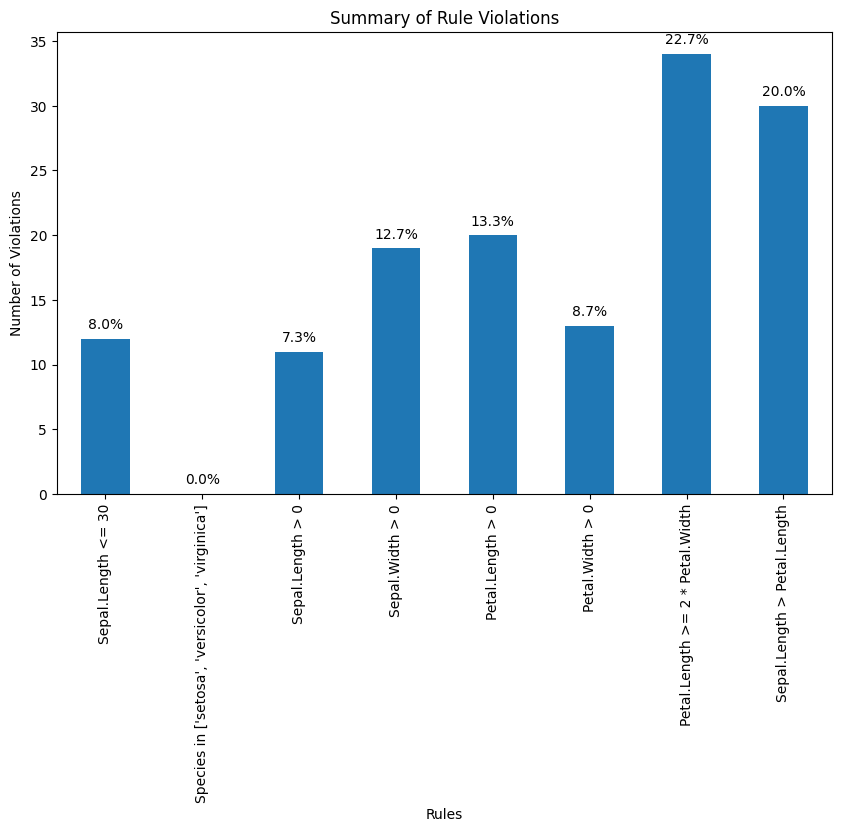

In [9]:
import matplotlib.pyplot as plt
# Plot the violations
violation_counts = pd.Series(summary)
ax = violation_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Summary of Rule Violations')
plt.xlabel('Rules')
plt.ylabel('Number of Violations')

# Add percentage labels above the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height() / len(dirty_iris) * 100:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points')

plt.show()

Find out which observations have too long sepals using the result of violations.

In [10]:
# Check for rule violations
violations = {rule: ~result for rule, result in rules.items()}
# Combine violations into a DataFrame
violated_df = pd.DataFrame(violations)
violated_rows = dirty_iris[violated_df["Sepal.Length <= 30"]]
print(violated_rows)

     Sepal.Length  Sepal.Width  Petal.Length  Petal.Width     Species
14            NaN          3.9          1.70          0.4      setosa
18            NaN          4.0           NaN          0.2      setosa
24            NaN          3.0          5.90          2.1   virginica
27           73.0         29.0         63.00          NaN   virginica
29            NaN          2.8          0.82          1.3  versicolor
57            NaN          2.9          4.50          1.5  versicolor
67            NaN          3.2          5.70          2.3   virginica
113           NaN          3.3          5.70          2.1   virginica
118           NaN          3.0          5.50          2.1   virginica
119           NaN          2.8          4.70          1.2  versicolor
124          49.0         30.0         14.00          2.0      setosa
137           NaN          3.0          4.90          1.8   virginica


Find outliers in sepal length using boxplot approach. Retrieve the corresponding observations and look at the other values. Any ideas what might have happened? Set the outliers to NA (or a value that you find more appropiate)

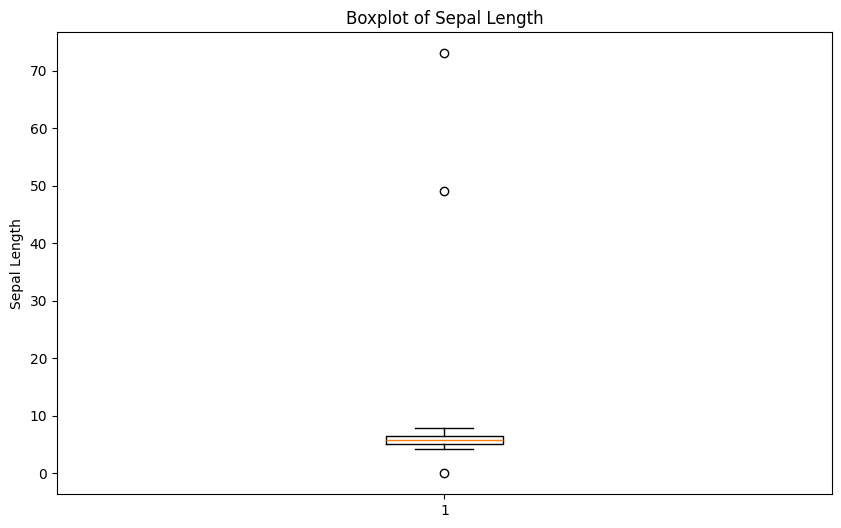

In [11]:
# Boxplot for Sepal.Length
plt.figure(figsize=(10, 6))
plt.boxplot(dirty_iris['Sepal.Length'].dropna())
plt.title('Boxplot of Sepal Length')
plt.ylabel('Sepal Length')
plt.show()

In [12]:
# Find outliers in Sepal.Length
outliers = dirty_iris['Sepal.Length'][np.abs(dirty_iris['Sepal.Length'] - dirty_iris['Sepal.Length'].mean()) > (1.5 * dirty_iris['Sepal.Length'].std())]
outliers_idx = dirty_iris.index[dirty_iris['Sepal.Length'].isin(outliers)]

# Print the rows with outliers
print("Outliers:")
print(dirty_iris.loc[outliers_idx])

Outliers:
     Sepal.Length  Sepal.Width  Petal.Length  Petal.Width    Species
27           73.0         29.0          63.0          NaN  virginica
124          49.0         30.0          14.0          2.0     setosa


They all seem to be too big... may they were measured in mm i.o cm?

In [13]:
# Adjust the outliers (assuming they were measured in mm instead of cm)
dirty_iris.loc[outliers_idx, ['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']] /= 10

# Summary of the adjusted data
print("Summary of adjusted data:")
print(dirty_iris.describe())

Summary of adjusted data:
       Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
count    140.000000   133.000000    131.000000   137.000000
mean       5.775000     2.991729      3.920954     1.194161
std        0.969842     0.708075      2.455417     0.766463
min        0.000000    -3.000000      0.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.700000     3.000000      4.400000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.200000     23.000000     2.500000



Note that simple boxplot shows an extra outlier!

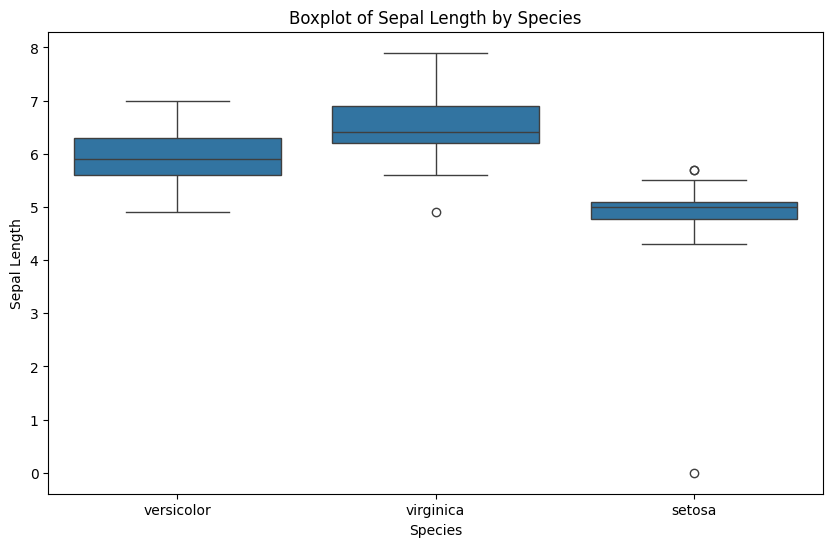

In [14]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x='Species', y='Sepal.Length', data=dirty_iris)
plt.title('Boxplot of Sepal Length by Species')
plt.xlabel('Species')
plt.ylabel('Sepal Length')
plt.show()

## Correcting

Replace non positive values from Sepal.Width with NA:

In [15]:
# Define the correction rule
def correct_sepal_width(df):
    df.loc[(~df['Sepal.Width'].isna()) & (df['Sepal.Width'] <= 0), 'Sepal.Width'] = np.nan
    return df

# Apply the correction rule to the dataframe
mydata_corrected = correct_sepal_width(dirty_iris)

# Print the corrected dataframe
print(mydata_corrected)

     Sepal.Length  Sepal.Width  Petal.Length  Petal.Width     Species
0             6.4          3.2           4.5          1.5  versicolor
1             6.3          3.3           6.0          2.5   virginica
2             6.2          NaN           5.4          2.3   virginica
3             5.0          3.4           1.6          0.4      setosa
4             5.7          2.6           3.5          1.0  versicolor
..            ...          ...           ...          ...         ...
145           6.7          3.1           5.6          2.4   virginica
146           5.6          3.0           4.5          1.5  versicolor
147           5.2          3.5           1.5          0.2      setosa
148           6.4          3.1           NaN          1.8   virginica
149           5.8          2.6           4.0          NaN  versicolor

[150 rows x 5 columns]


Replace all erroneous values with NA using (the result of) localizeErrors:

In [16]:
# Apply the rules to the dataframe
rules = check_rules(dirty_iris)
violations = {rule: ~result for rule, result in rules.items()}
violated_df = pd.DataFrame(violations)

# Localize errors and set them to NA
for col in violated_df.columns:
    dirty_iris.loc[violated_df[col], col.split()[0]] = np.nan

## NA's pattern detection

Here we are going to use **missingno** library to diagnose the missingness pattern for the 'dirty_iris' dataset.

In [17]:
import missingno as msno

### Matrix Plot (msno.matrix):

This visualization shows which values are missing in each column. Each bar represents a column, and white spaces in the bars indicate missing values.

If you see many white spaces in one column, it means that column has a lot of missing data.
If the white spaces are randomly scattered, the missing data might be random. 
If they are clustered in specific areas, it might indicate a pattern.

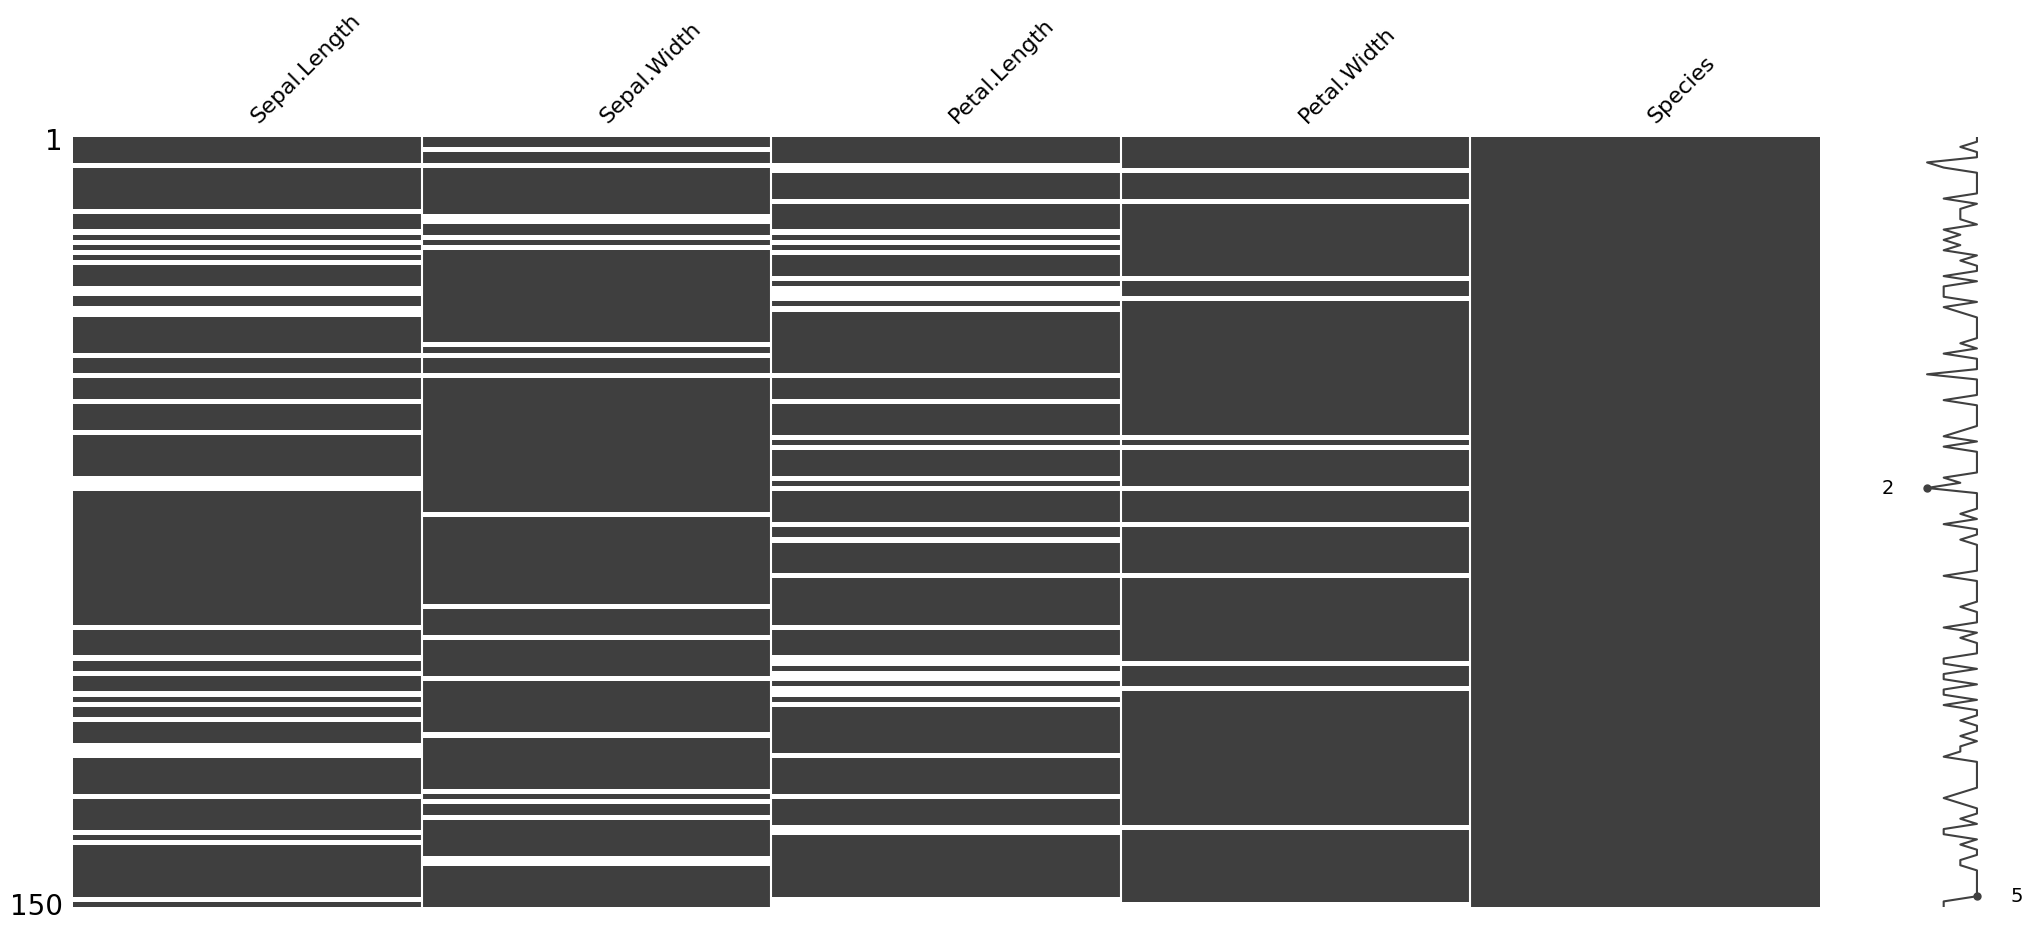

In [18]:
msno.matrix(dirty_iris);

### Heatmap Plot (msno.heatmap):

This visualization shows the correlations between missing values in different columns.
If two columns have a high correlation (dark colors), it means that if one column has missing values, the other column is also likely to have missing values.

Low correlations (light colors) indicate that missing values in one column are not related to missing values in another column.

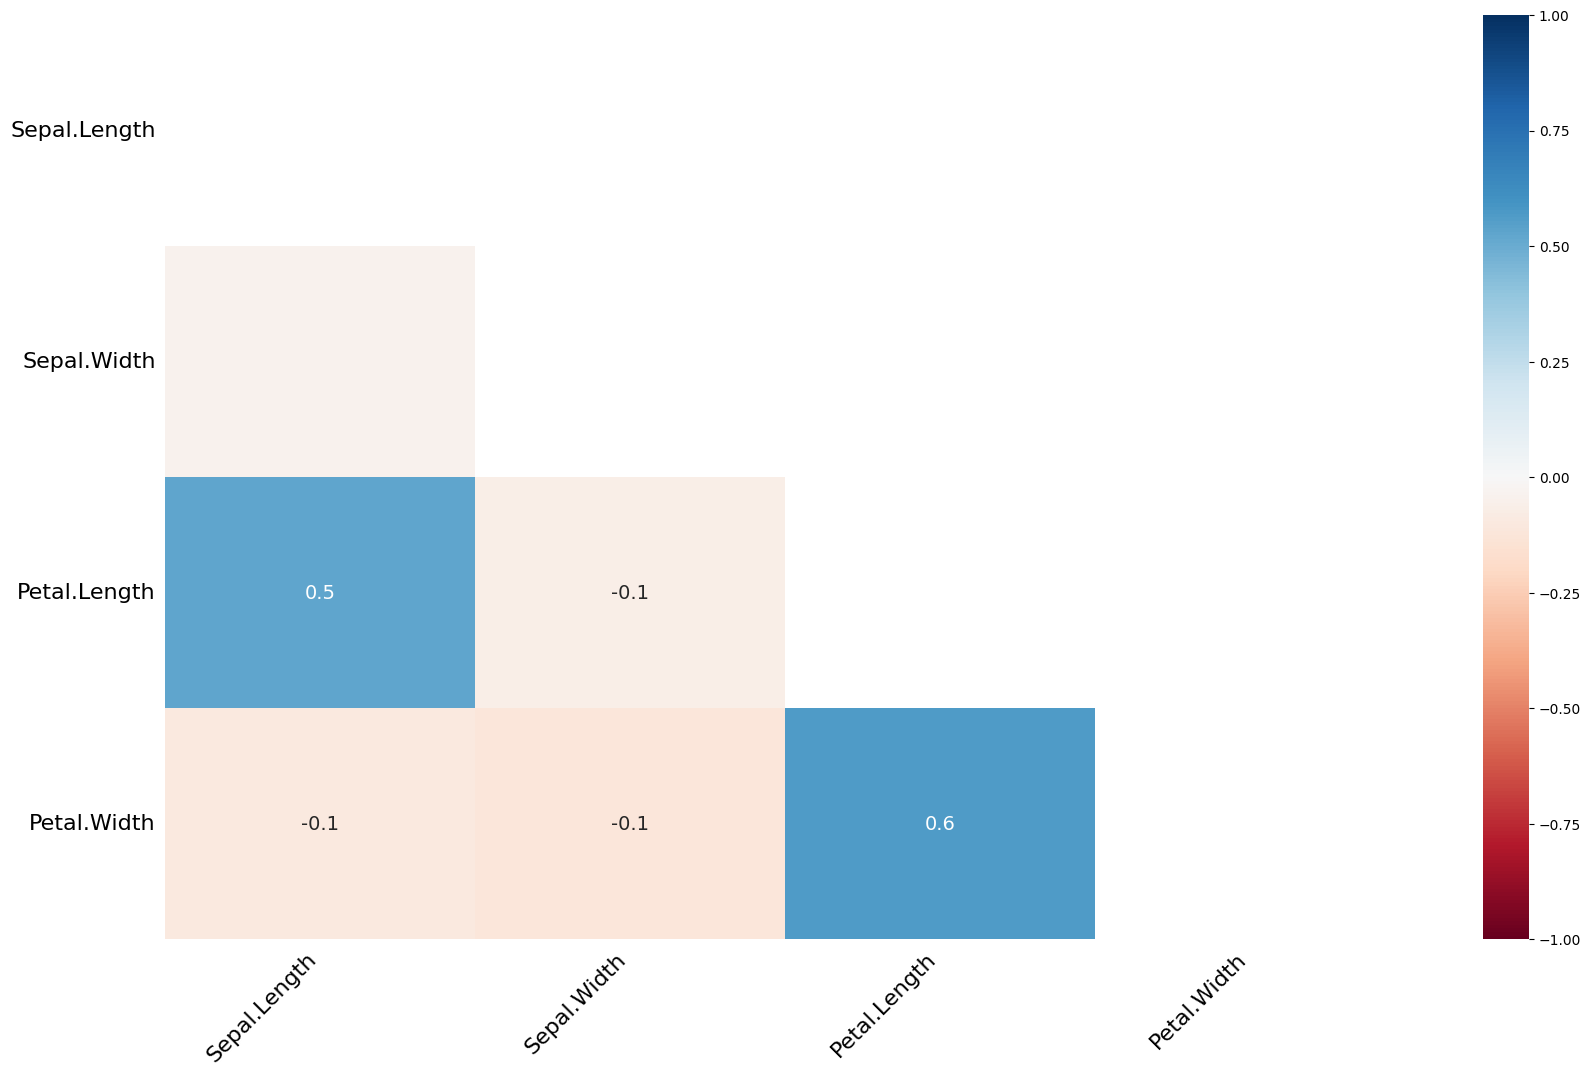

In [19]:
msno.heatmap(dirty_iris);

### Dendrogram Plot (msno.dendrogram):

This visualization groups columns based on the similarity of their missing data patterns.
Columns that are close to each other in the dendrogram have similar patterns of missing data.

This can help identify groups of columns that have similar issues with missing data.

Based on these visualizations, we can identify which columns have the most missing data, whether the missing data is random or patterned, and which columns have similar patterns of missing data.

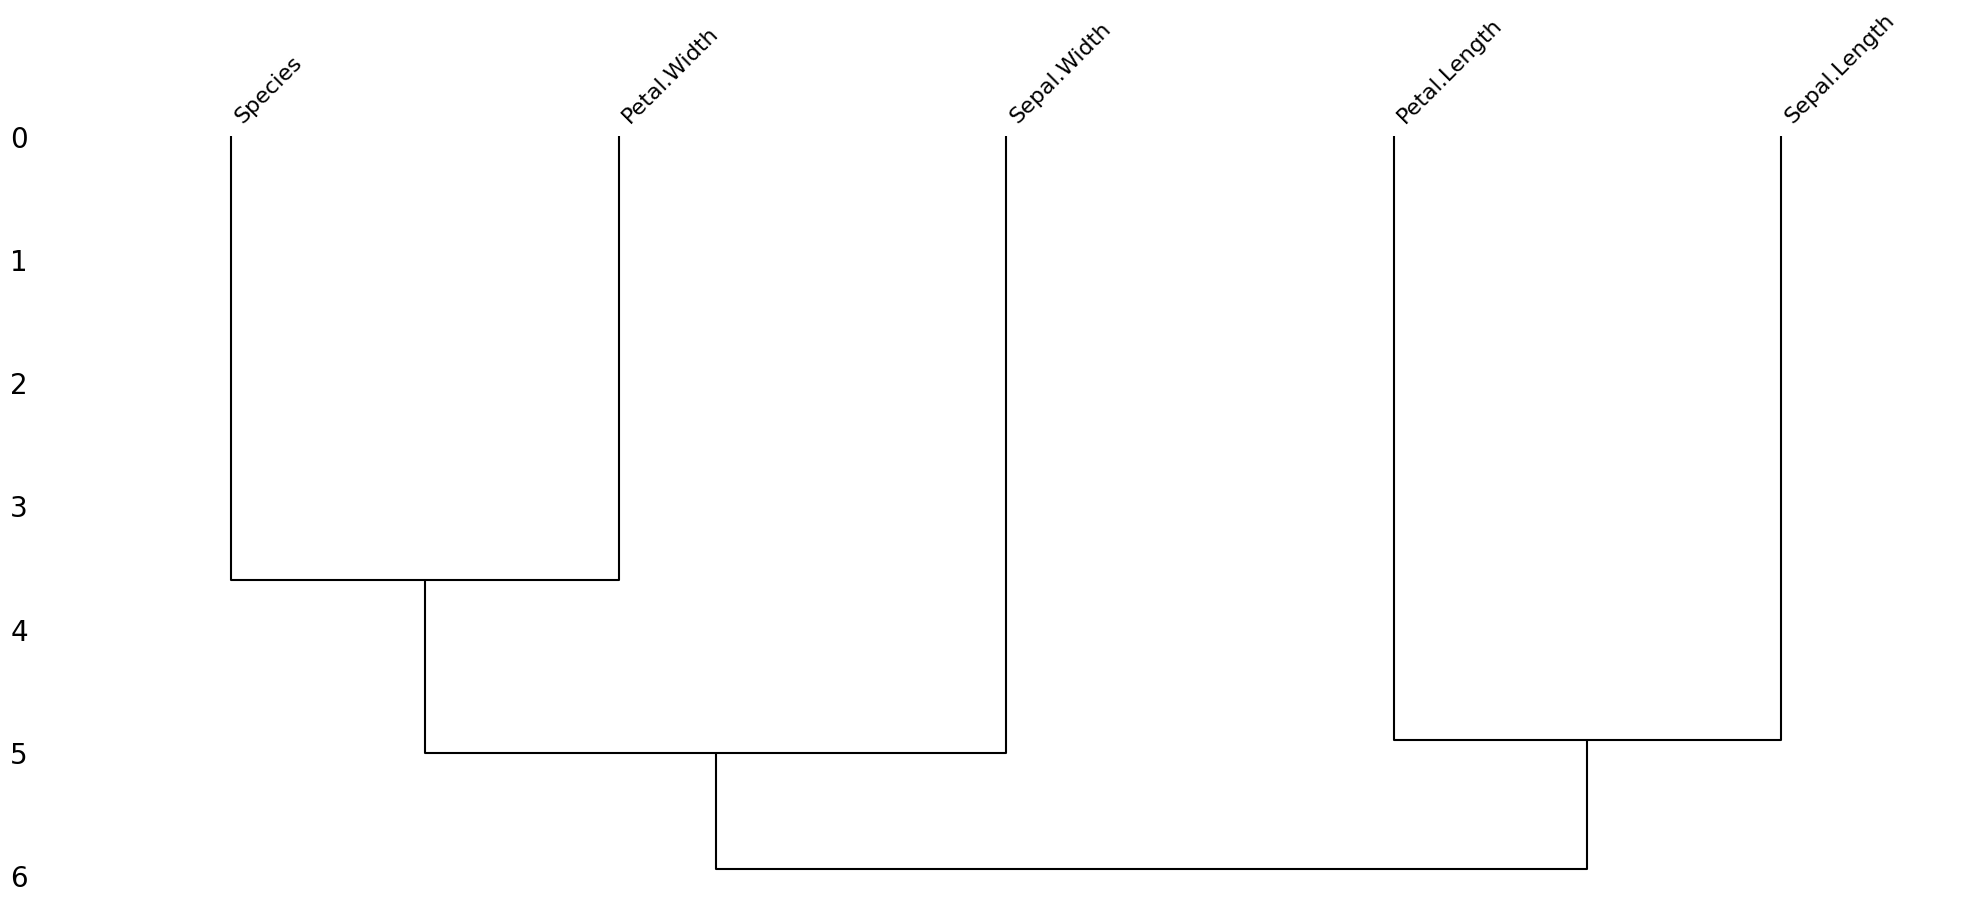

In [20]:
msno.dendrogram(dirty_iris);

*Based on the dendrogram plot, we can interpret the pattern of missing data in the "dirty iris" dataset as follows:*

**Grouping of Columns:**

The dendrogram shows that the columns "Species" and "Petal.Width" are grouped together, indicating that they have similar patterns of missing data.

Similarly, "Sepal.Width" and "Petal.Length" are grouped together, suggesting they also share a similar pattern of missing data.

"Sepal.Length" is somewhat separate from the other groups, indicating it has a different pattern of missing data compared to the other columns.

**Pattern of Missing Data:**

The grouping suggests that missing data in "Species" is likely to be associated with missing data in "Petal.Width".

Similarly, missing data in "Sepal.Width" is likely to be associated with missing data in "Petal.Length".

"Sepal.Length" appears to have a distinct pattern of missing data that is not strongly associated with the other columns.

*From this dendrogram, we can infer that the missing data is not completely random. Instead, there are specific patterns where certain columns tend to have missing data together. This indicates a systematic pattern of missing data rather than a purely random one.*

## Imputing NA's

Imputation is the process of estimating or deriving values for fields where data is missing. There is a vast body of literature on imputation methods and it goes beyond the scope of this tutorial to discuss all of them.

There is no one single best imputation method that works in all cases. The imputation model of choice depends on what auxiliary information is available and whether there are (multivariate) edit restrictions on the data to be imputed. 

The availability of Python software for imputation under edit restrictions is, to our best knowledge, limited. However, a viable strategy for imputing numerical data is to first impute missing values without restrictions, and then minimally adjust the imputed values so that the restrictions are obeyed. Separately, these methods are available in Python.

We can mention several approaches to imputation:

1.  For the **quantitative** variables:

-   imputing by **mean**/**median**/**mode**

-   **hotdeck** imputation

-   **KNN** -- K-nearest-neighbors approach

-   **RPART** -- random forests multivariate approach

-   **mice** - Multivariate Imputation by Chained Equations approach

2.  For the **qualitative** variables:

-   imputing by **mode**

-   **RPART** -- random forests multivariate approach

-   **mice** - Multivariate Imputation by Chained Equations approach

    ... and many others. Please read the theoretical background if you are interested in those techniques.



***Exercise 1.*** Use ***kNN*** imputation ('sklearn' package) to impute all missing values. The KNNImputer from sklearn requires all data to be numeric. Since our dataset contains categorical data (e.g., the Species column), you need to handle these columns separately. One approach is to use one-hot encoding for categorical variables before applying the imputer.

In [21]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
# Replace infinite values with NaN
dirty_iris.replace([np.inf, -np.inf], np.nan, inplace=True)

# Separate numeric and categorical columns
numeric_cols = dirty_iris.select_dtypes(include=[np.number]).columns
categorical_cols = dirty_iris.select_dtypes(exclude=[np.number]).columns
# One-hot encode categorical columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoded_categorical = pd.DataFrame(encoder.fit_transform(dirty_iris[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))

# Combine numeric and encoded categorical columns
combined_data = pd.concat([dirty_iris[numeric_cols], encoded_categorical], axis=1)

# Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=3)

# Perform kNN imputation
imputed_data = imputer.fit_transform(combined_data)

# Convert the imputed data back to a DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=combined_data.columns)

# Decode the one-hot encoded columns back to original categorical columns
decoded_categorical = pd.DataFrame(encoder.inverse_transform(imputed_df[encoded_categorical.columns]), columns=categorical_cols)

# Combine numeric and decoded categorical columns
final_imputed_data = pd.concat([imputed_df[numeric_cols], decoded_categorical], axis=1)

# Print the imputed data
print(final_imputed_data)

     Sepal.Length  Sepal.Width  Petal.Length  Petal.Width     Species
0        6.400000     3.200000      4.500000     1.500000  versicolor
1        6.300000     3.300000      6.000000     2.500000   virginica
2        6.200000     3.033333      5.400000     2.300000   virginica
3        5.000000     3.400000      1.600000     0.400000      setosa
4        5.700000     2.600000      3.500000     1.000000  versicolor
..            ...          ...           ...          ...         ...
145      6.700000     3.100000      5.600000     2.400000   virginica
146      5.600000     3.000000      4.500000     1.500000  versicolor
147      5.200000     3.500000      1.500000     0.200000      setosa
148      6.533333     3.100000      5.166667     1.800000   virginica
149      5.800000     2.600000      3.833333     1.066667  versicolor

[150 rows x 5 columns]


## Transformations

Finally, we sometimes encounter the situation where we have problems with skewed distributions or we just want to transform, recode or perform discretization. Let's review some of the most popular transformation methods.

First, standardization (also known as normalization):

-   **Z-score** approach - standardization procedure, using the formula: $z=\frac{x-\mu}{\sigma}$ where $\mu$ = mean and $\sigma$ = standard deviation. Z-scores are also known as standardized scores; they are scores (or data values) that have been given a common *standard*. This standard is a mean of zero and a standard deviation of 1.

-   **minmax** approach - An alternative approach to Z-score normalization (or standardization) is the so-called MinMax scaling (often also simply called "normalization" - a common cause for ambiguities). In this approach, the data is scaled to a fixed range - usually 0 to 1. The cost of having this bounded range - in contrast to standardization - is that we will end up with smaller standard deviations, which can suppress the effect of outliers. If you would like to perform MinMax scaling - simply substract minimum value and divide it by range:$(x-min)/(max-min)$

In order to solve problems with very skewed distributions we can also use several types of simple transformations:

-   log
-   log+1
-   sqrt
-   x\^2
-   x\^3

***Exercise 2.*** Standardize incomes and present the transformed distribution of incomes on boxplot.

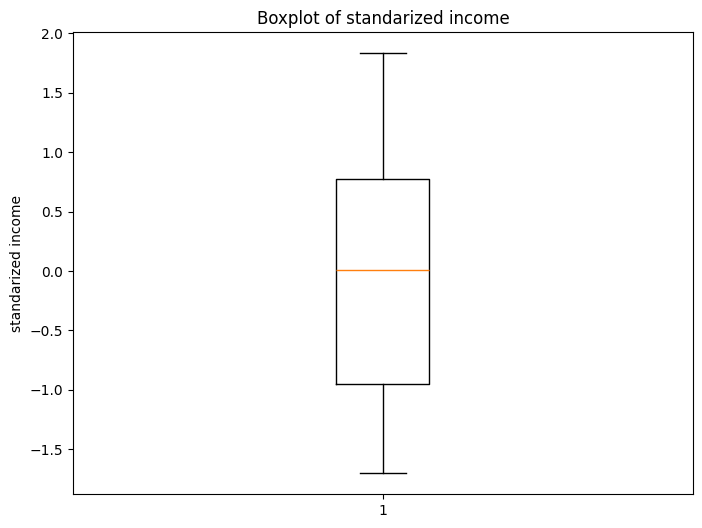

20


In [ ]:
standarized_income = (carseats['Income'] - carseats['Income'].mean()) / carseats['Income'].std()

# making boxplot

plt.figure(figsize=(8, 6))
plt.boxplot(standarized_income.dropna())
plt.title('Boxplot of standarized income')
plt.ylabel('standarized income')
plt.show()


## Binning

Sometimes we just would like to perform so called 'binning' procedure to be able to analyze our categorical data, to compare several categorical variables, to construct statistical models etc. Thanks to the 'binning' function we can transform quantitative variables into categorical using several methods:

-   **quantile** - automatic binning by quantile of its distribution

-   **equal** - binning to achieve fixed length of intervals

-   **pretty** - a compromise between the 2 mentioned above

-   **kmeans** - categorization using the K-Means algorithm

-   **bclust** - categorization using the bagged clustering algorithm

**Exercise 3.** Using quantile approach perform binning of the variable 'Income'.

In [31]:
# your code goes here

income_binned = pd.qcut(carseats['Income'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

print(income_binned)

0           High
1         Medium
2            Low
3      Very High
4         Medium
         ...    
395    Very High
396          Low
397          Low
398         High
399          Low
Name: Income, Length: 400, dtype: category
Categories (4, object): ['Low' < 'Medium' < 'High' < 'Very High']


**Exercise 4.** Recode the original distribution of incomes using fixed length of intervals and assign them labels.


In [32]:
# your code goes here

income_binned_fixed = pd.cut(carseats['Income'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

print(income_binned_fixed)

0         Medium
1            Low
2       Very Low
3           High
4         Medium
         ...    
395    Very High
396     Very Low
397     Very Low
398       Medium
399     Very Low
Name: Income, Length: 400, dtype: category
Categories (5, object): ['Very Low' < 'Low' < 'Medium' < 'High' < 'Very High']


In case of statistical modeling (i.e. credit scoring purposes) - we need to be aware of the fact, that the ***optimal*** discretization of the original distribution must be achieved. The '*binning_by*' function comes with some help here.

## Optimal binning with binary target

**Exercise 5.** Perform discretization of the variable 'Advertising' using optimal binning.

In [34]:
from optbinning import OptimalBinning
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)

We choose a variable to discretize and the binary target.

In [35]:
variable = "mean radius"
x = df[variable].values
y = data.target

Import and instantiate an OptimalBinning object class. We pass the variable name, its data type, and a solver, in this case, we choose the constraint programming solver.

In [36]:
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")

We fit the optimal binning object with arrays x and y.

In [37]:
optb.fit(x, y)

OptimalBinning(name='mean radius')

You can check if an optimal solution has been found via the status attribute:

In [38]:
optb.status

'OPTIMAL'

You can also retrieve the optimal split points via the splits attribute:

In [39]:
optb.splits

array([11.42500019, 12.32999992, 13.09499979, 13.70499992, 15.04500008,
       16.92500019])

The binning table

The optimal binning algorithms return a binning table; a binning table displays the binned data and several metrics for each bin. Class OptimalBinning returns an object BinningTable via the binning_table attribute.

In [40]:
binning_table = optb.binning_table

type(binning_table)

optbinning.binning.binning_statistics.BinningTable

The binning_table is instantiated, but not built. Therefore, the first step is to call the method build, which returns a pandas.DataFrame.

In [41]:
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 11.43)",118,0.207381,3,115,0.974576,-3.12517,0.962483,0.087205
1,"[11.43, 12.33)",79,0.138840,3,76,0.962025,-2.710972,0.538763,0.052198
2,"[12.33, 13.09)",68,0.119508,7,61,0.897059,-1.643814,0.226599,0.025513
3,"[13.09, 13.70)",49,0.086116,10,39,0.795918,-0.839827,0.052131,0.006331
4,"[13.70, 15.05)",83,0.145870,28,55,0.662651,-0.153979,0.003385,0.000423
5,"[15.05, 16.93)",54,0.094903,44,10,0.185185,2.002754,0.359566,0.038678
6,"[16.93, inf)",118,0.207381,117,1,0.008475,5.283323,2.900997,0.183436
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,569,1.000000,212,357,0.627417,,5.043925,0.393784


Let’s describe the columns of this binning table:

Bin: the intervals delimited by the optimal split points.  
Count: the number of records for each bin.  
Count (%): the percentage of records for each bin.  
Non-event: the number of non-event records (𝑦=0) for each bin.  
Event: the number of event records (𝑦=1) for each bin.  
Event rate: the percentage of event records for each bin.  
WoE: the Weight-of-Evidence for each bin.  
IV: the Information Value (also known as Jeffrey’s divergence) for each bin.  
JS: the Jensen-Shannon divergence for each bin.  
The last row shows the total number of records, non-event records, event records, and IV and JS.    

You can use the method plot to visualize the histogram and WoE or event rate curve. Note that the Bin ID corresponds to the binning table index.

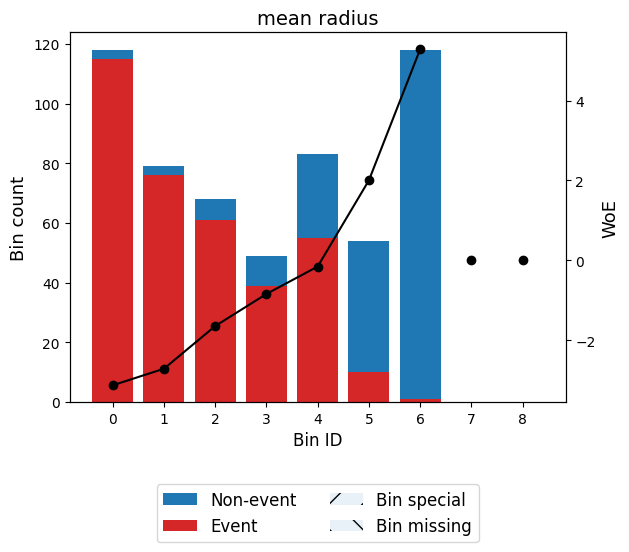

In [42]:
binning_table.plot(metric="woe")

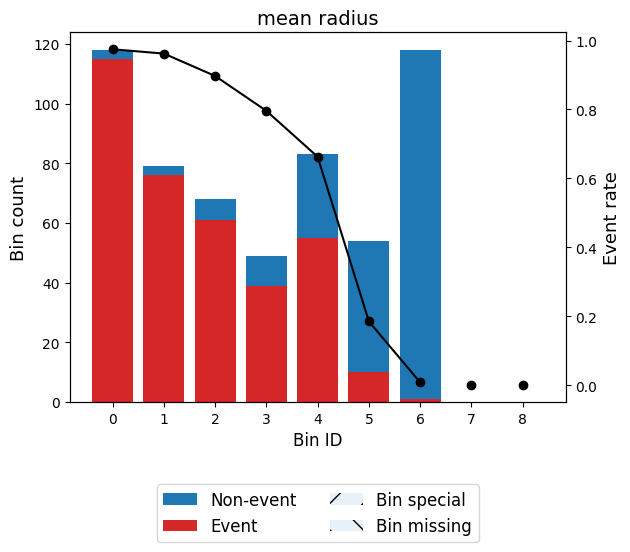

In [43]:
binning_table.plot(metric="event_rate")

Note that WoE is inversely related to the event rate, i.e., a monotonically ascending event rate ensures a monotonically descending WoE and vice-versa. We will see more monotonic trend options in the advanced tutorial.

Read more here: [https://gnpalencia.org/optbinning/tutorials/tutorial_binary.html](https://gnpalencia.org/optbinning/tutorials/tutorial_binary.html)

## Working with 'missingno' library

<iframe width="560" height="315" src="https://www.youtube.com/embed/Wdvwer7h-8w?si=pVqCbOXb4CaCsmnJ" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

**Exercise 6.** Your turn! 

Work with the 'carseats' dataset, find the best way to perform full diagnostic (dirty data, outliers, missing values). Fix problems.

In [48]:
# your code goes here

num_of_complete_rows = carseats.dropna().shape[0]

percentage_complete_rows = (num_of_complete_rows / carseats.shape[0]) * 100

print(f"Number of complete rows: {complete_cases}")
print(f"Percentage of complete rows: {percentage_complete:.2f}%")

# handling special values
# using function that was already defined

for collumn in carseats.columns:
    carseats[collumn] = carseats[collumn].apply(lambda x: np.nan if is_special(pd.Series([x]))[0] else x)

# displaying summary of the data
print(carseats.describe(include='all'))

carseats

Number of complete rows: 96
Percentage of complete rows: 64.00%
             Sales   CompPrice      Income  Advertising  Population  \
count   400.000000  400.000000  380.000000   400.000000  400.000000   
unique         NaN         NaN         NaN          NaN         NaN   
top            NaN         NaN         NaN          NaN         NaN   
freq           NaN         NaN         NaN          NaN         NaN   
mean      7.496325  124.975000   68.660526     6.635000  264.840000   
std       2.824115   15.334512   28.007218     6.650364  147.376436   
min       0.000000   77.000000   21.000000     0.000000   10.000000   
25%       5.390000  115.000000   42.000000     0.000000  139.000000   
50%       7.490000  125.000000   69.000000     5.000000  272.000000   
75%       9.320000  135.000000   90.250000    12.000000  398.500000   
max      16.270000  175.000000  120.000000    29.000000  509.000000   

             Price ShelveLoc         Age   Education Urban   US  
count   400.00000

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73.0,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48.0,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35.0,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100.0,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64.0,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108.0,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23.0,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26.0,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79.0,7,284,95,Bad,50,12,Yes,Yes


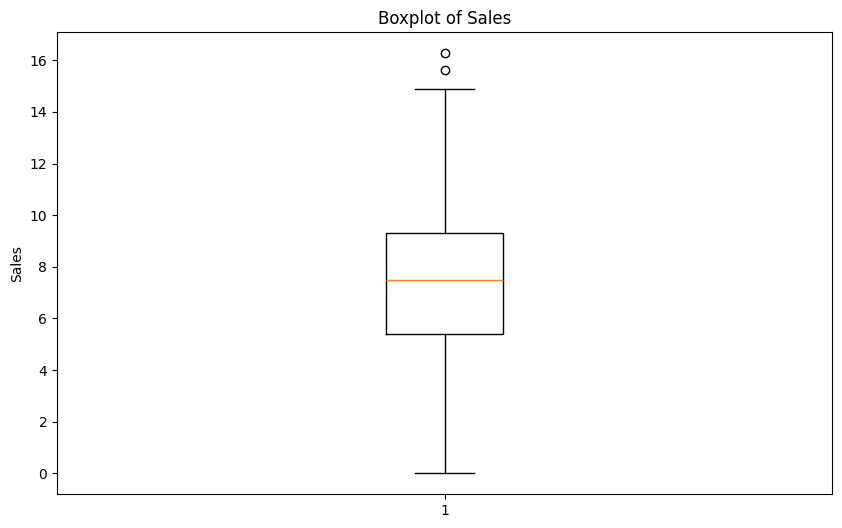

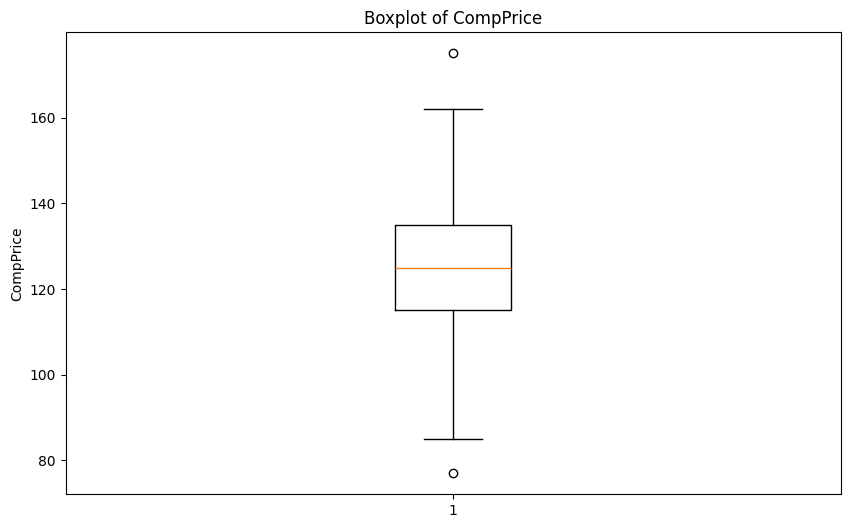

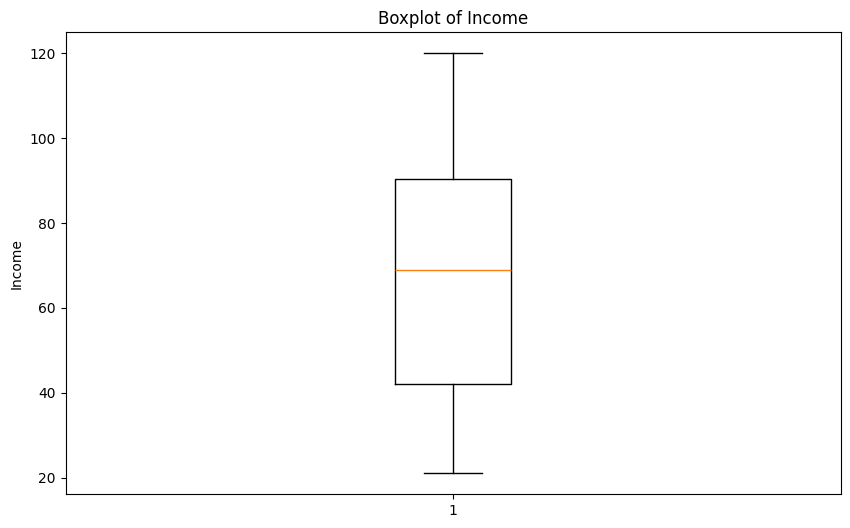

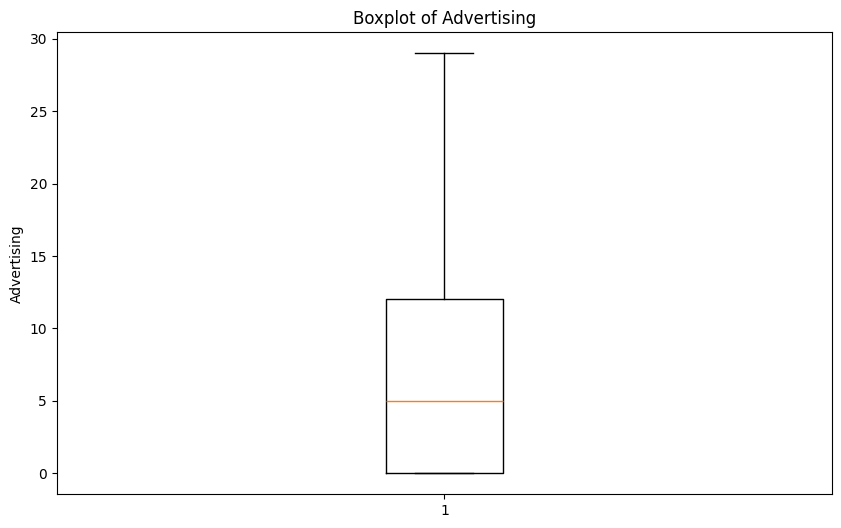

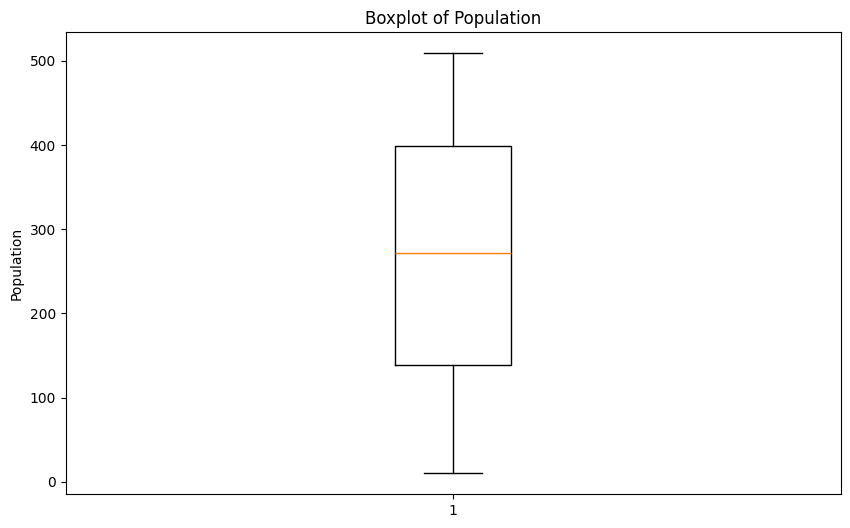

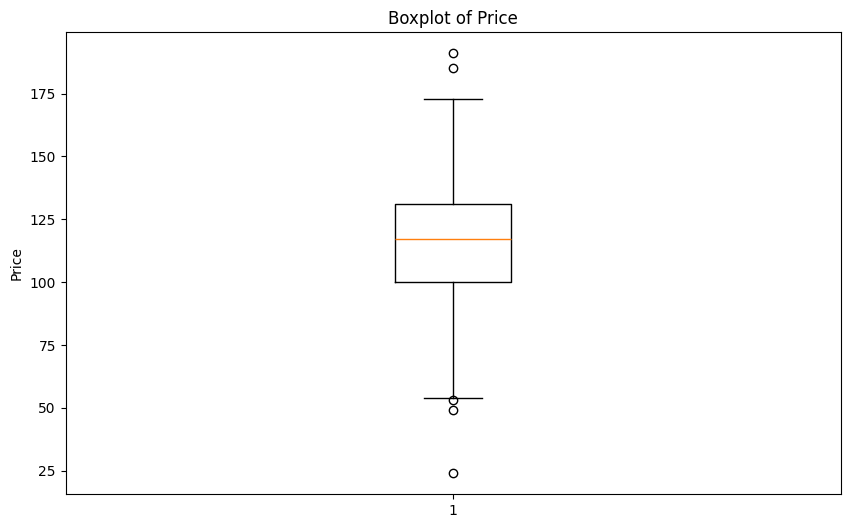

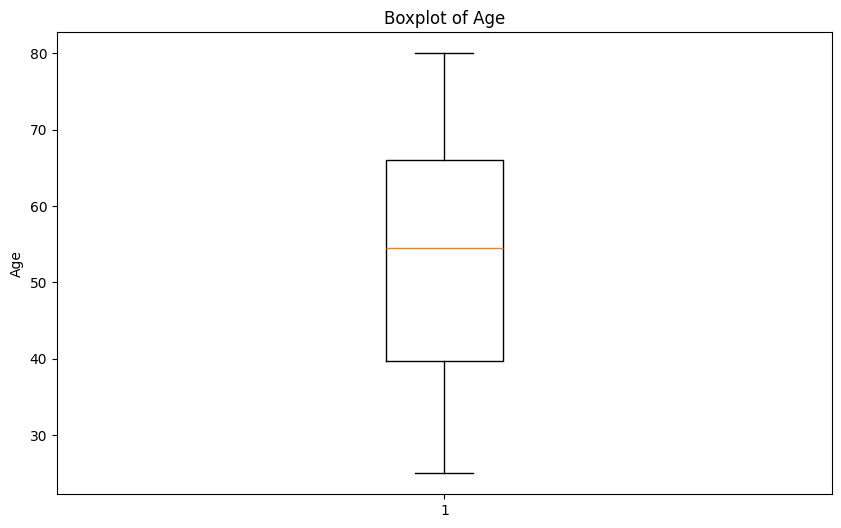

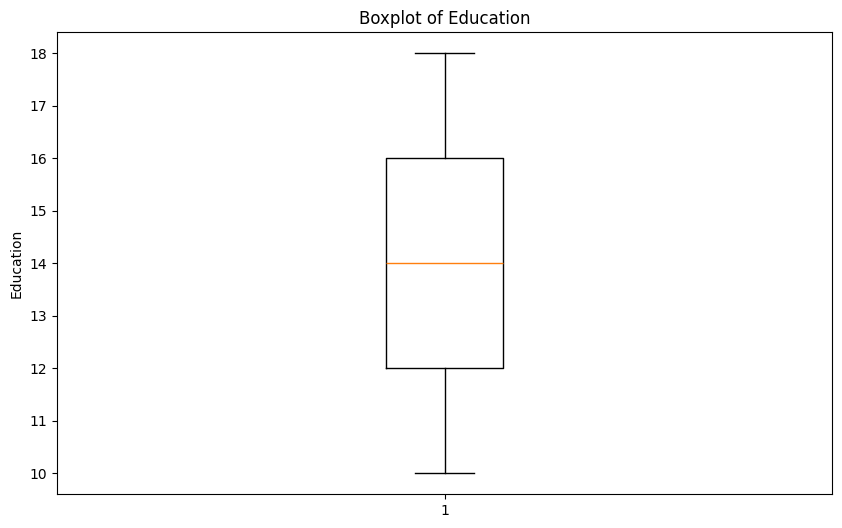

In [ ]:
# looking at the summary of data there are no obvious errors in the data (eg. negative prices, negative sales, etc.)
# we also have no other specified rules to check for errors in the data
# therefore I think we can skip the rule checking part


# checking for outliers in the data
# using boxplots to visualize the data
strings = ['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education']

for s in strings:
    plt.figure(figsize=(10, 6))
    plt.boxplot(carseats[s].dropna())
    plt.title('Boxplot of ' + s)
    plt.ylabel(s)
    plt.show()

In [ ]:
# found outliers in: Sales, CompPrice, Price
# looking at them we can see that they do not stand out as much, we can imagine that there are some products with anormous prices or very high sales
# we can assume that these are not errors in the data, but rather just products that are very popular or very expensive


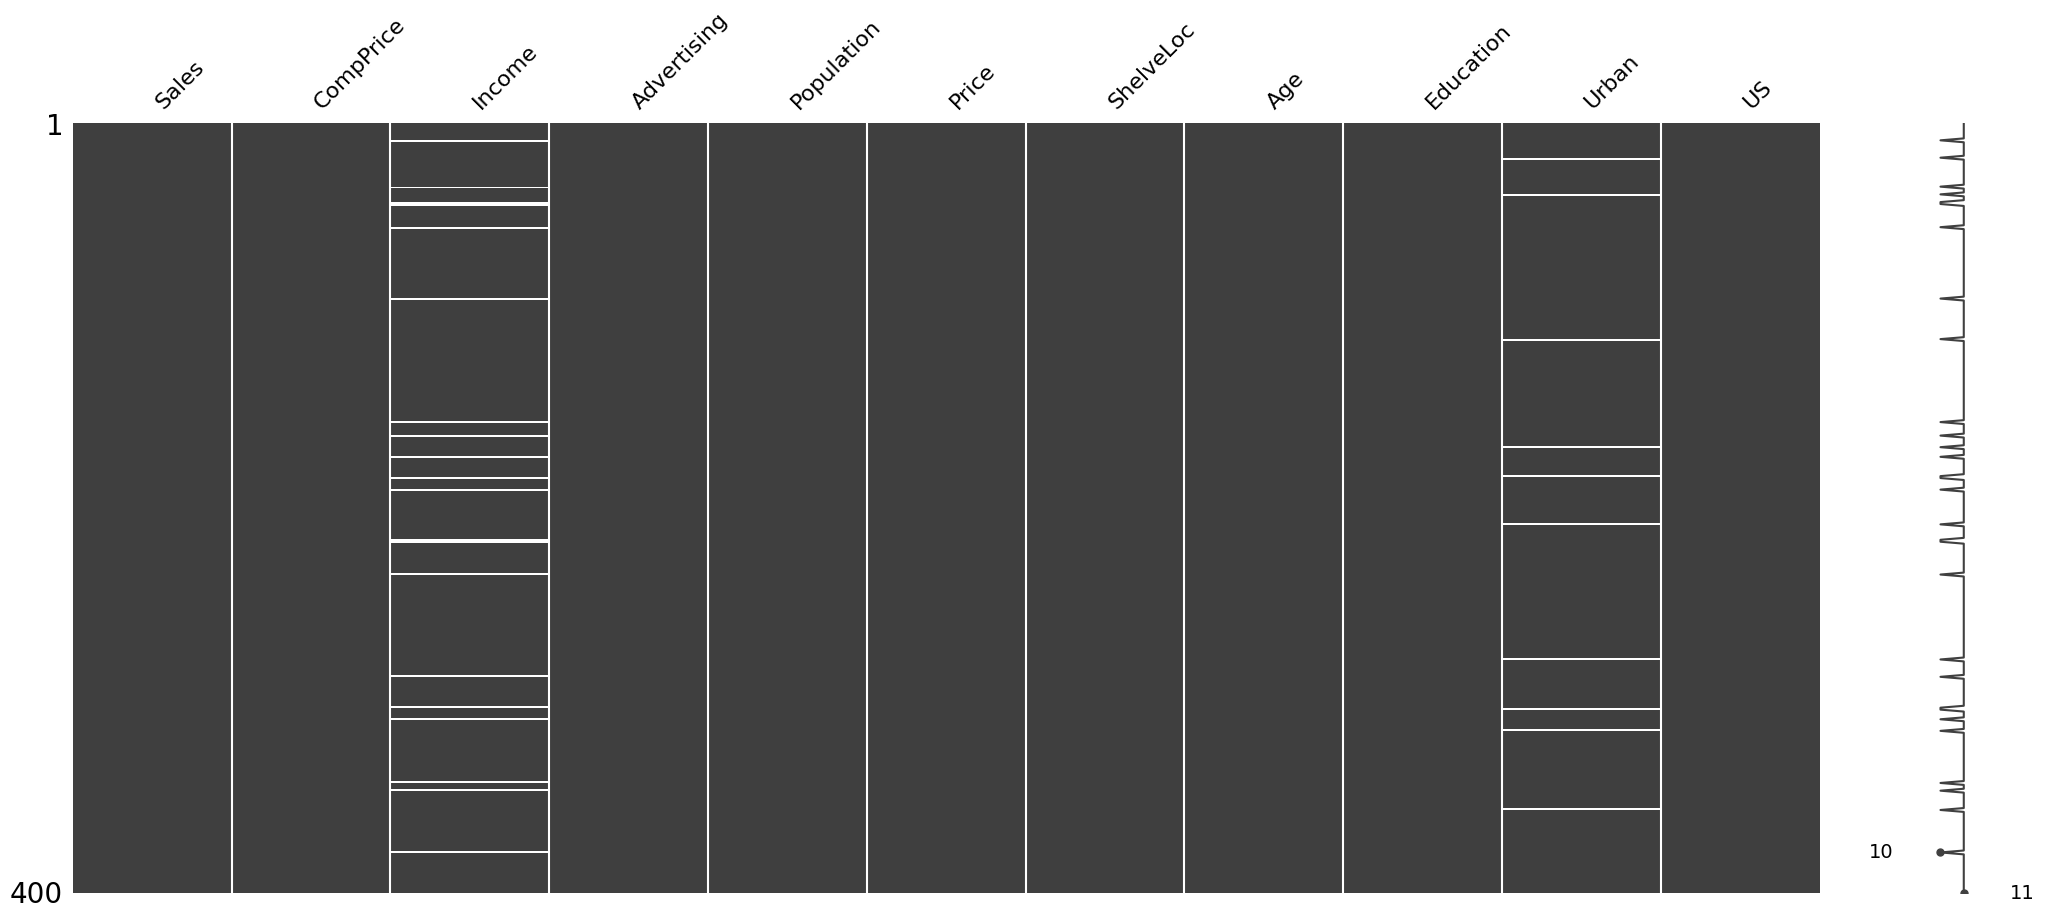

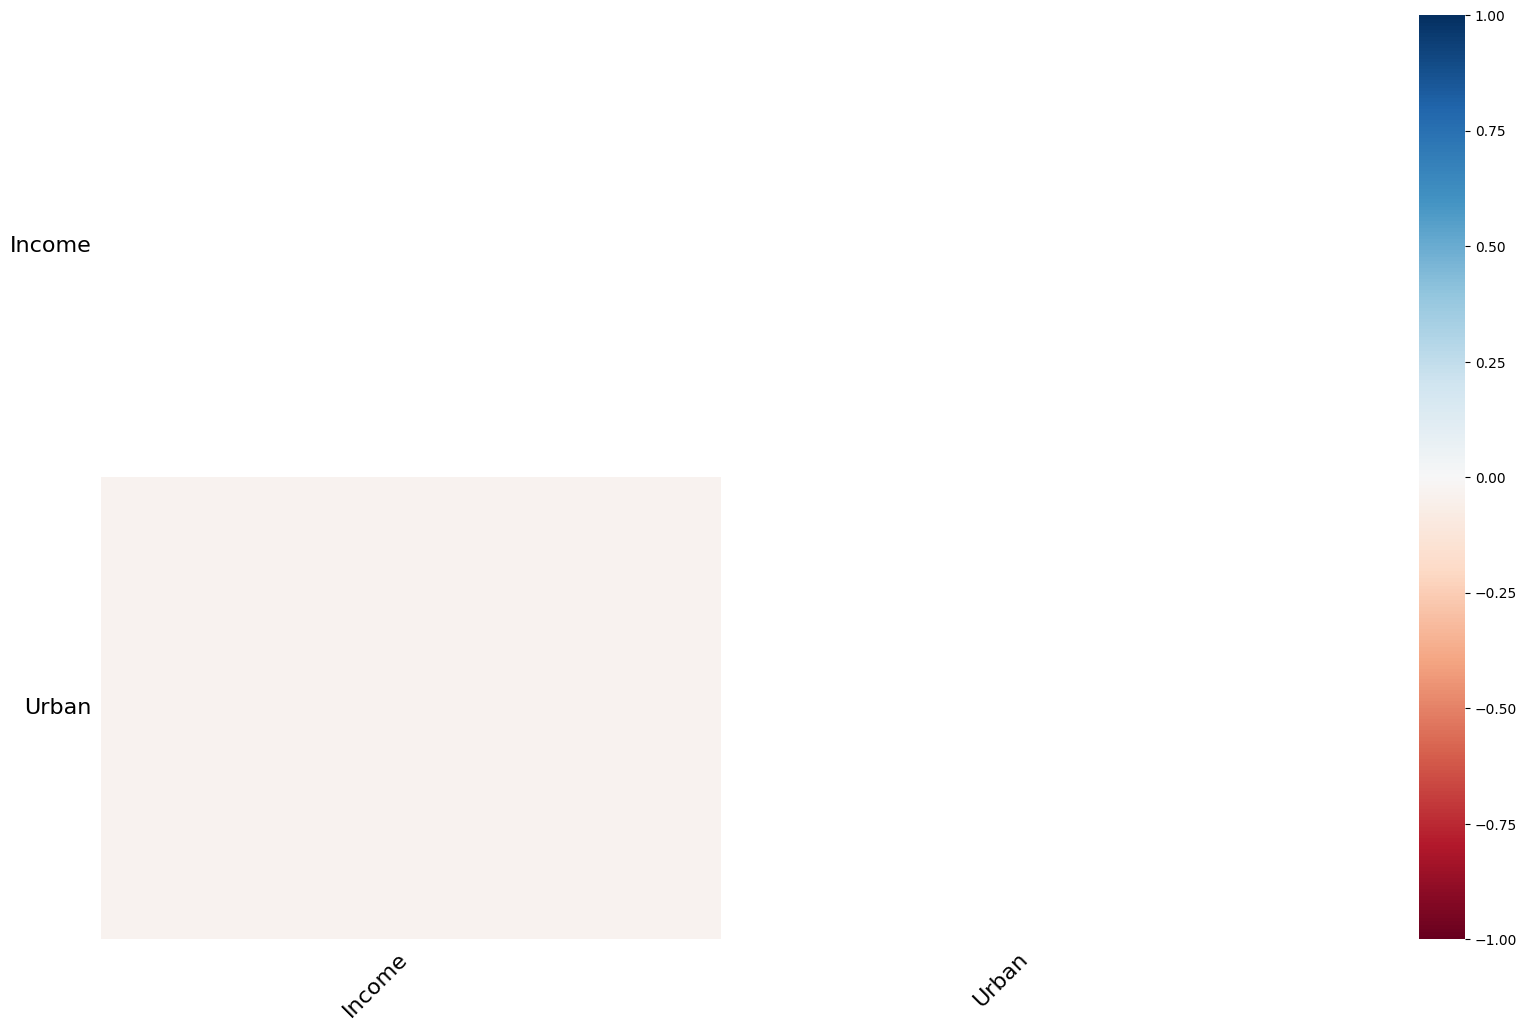

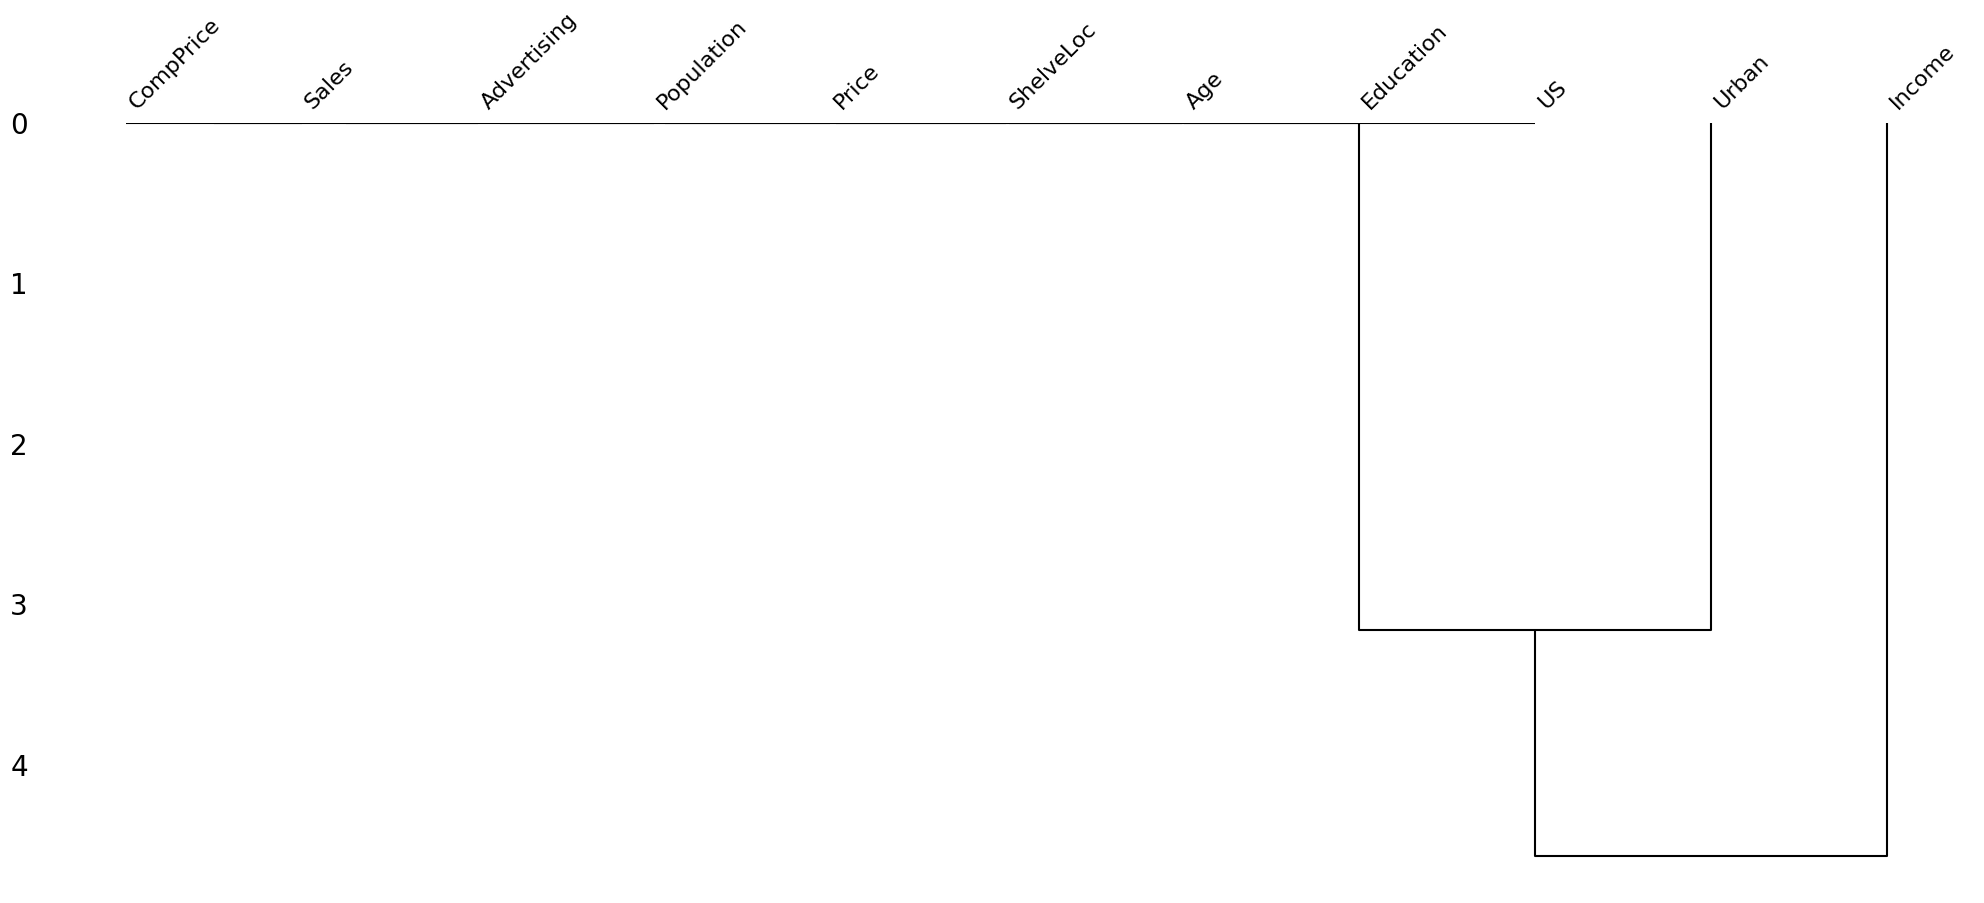

In [63]:
# checking for NAs in the data

msno.matrix(carseats);
msno.heatmap(carseats);
msno.dendrogram(carseats);

In [81]:
# looking at missingno plots we can see that there are some NAs in the data, but they are not very numerous and do not seem to be related to each other
# we can assume that they are random and not related to any other variable in the data

# we have missing values in the income column and urban column
# the urban column is qualitative therefor we can use MICE to impute the missing values

# I encountered many problems with the MICE imputer in sklearn, so I decided to use the node imputation

mode_value_urban = carseats['Urban'].mode()[0]
carseats['Urban'].fillna(mode_value_urban, inplace=True)

# Another column with missing values is the income column
# this column contains quantitative data, so we can use the KNN imputer to impute the missing values

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

# because sklearn imputers expect numeric data we need to convert the categorical data to numeric

numeric_columns = carseats.select_dtypes(include=[np.number]).columns
categorical_columns = carseats.select_dtypes(exclude=[np.number]).columns

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoded_categorical = pd.DataFrame(encoder.fit_transform(carseats[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))
combined_data = pd.concat([carseats[numeric_columns], encoded_categorical], axis=1)

imputer = KNNImputer(n_neighbors=3)

imputed_data = imputer.fit_transform(combined_data)
imputed_df = pd.DataFrame(imputed_data, columns=combined_data.columns)

decoded_categorical = pd.DataFrame(encoder.inverse_transform(imputed_df[encoded_categorical.columns]), columns=categorical_columns)

final_imputed_data = pd.concat([imputed_df[numeric_columns], decoded_categorical], axis=1)


print(final_imputed_data.isna().sum())

print(final_imputed_data)

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
Age            0
Education      0
ShelveLoc      0
Urban          0
US             0
dtype: int64
     Sales  CompPrice  Income  Advertising  Population  Price   Age  \
0     9.50      138.0    73.0         11.0       276.0  120.0  42.0   
1    11.22      111.0    48.0         16.0       260.0   83.0  65.0   
2    10.06      113.0    35.0         10.0       269.0   80.0  59.0   
3     7.40      117.0   100.0          4.0       466.0   97.0  55.0   
4     4.15      141.0    64.0          3.0       340.0  128.0  38.0   
..     ...        ...     ...          ...         ...    ...   ...   
395  12.57      138.0   108.0         17.0       203.0  128.0  33.0   
396   6.14      139.0    23.0          3.0        37.0  120.0  55.0   
397   7.41      162.0    26.0         12.0       368.0  159.0  40.0   
398   5.94      100.0    79.0          7.0       284.0   95.0  50.0   
399   9.71      134